## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [68]:
import pandas as pd

In [69]:
df = pd.read_csv("train.csv")
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [59]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk.stem import PorterStemmer

import string
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wandr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wandr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wandr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wandr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [71]:
df.shape

(404290, 6)

In [73]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [74]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [76]:
df = df.dropna()

In [78]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [79]:
df.shape

(404287, 6)

In [80]:
df = df.rename(columns = {'question1':'Q1'})
df = df.rename(columns = {'question2':'Q2'})

In [82]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<function matplotlib.pyplot.show(close=None, block=None)>

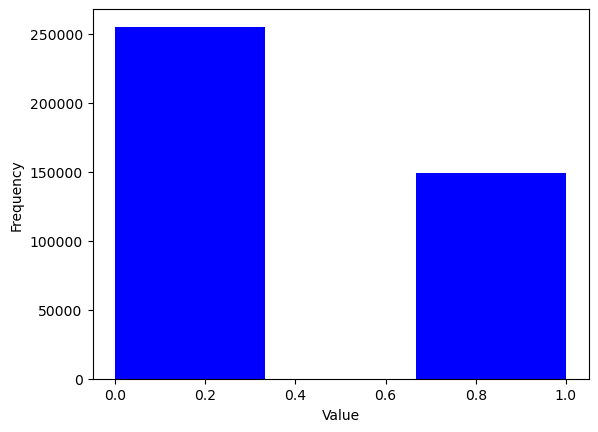

In [83]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df['is_duplicate'], bins=3, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.text
plt.show

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [84]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [85]:
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [86]:
df['Q1_clean'] = df['Q1'].astype(str).apply(lambda x: remove_punct(x))
df['Q2_clean'] = df['Q2'].astype(str).apply(lambda x: remove_punct(x))

In [87]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor KohiNoor Diamond,What would happen if the Indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely How can I solve it,Find the remainder when math2324math is divide...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,Which one dissolve in water quikly sugar salt ...,Which fish would survive in salt water


In [88]:
import re
def tokenize(text):
    tokens = text.split()
    return tokens

In [89]:
df['Q1_clean'] = df['Q1_clean'].apply(lambda x: tokenize(x.lower()))
df['Q2_clean'] = df['Q2_clean'].apply(lambda x: tokenize(x.lower()))

In [91]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[what, is, the, step, by, step, guide, to, inv...","[what, is, the, step, by, step, guide, to, inv..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[what, is, the, story, of, kohinoor, kohinoor,...","[what, would, happen, if, the, indian, governm..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[how, can, i, increase, the, speed, of, my, in...","[how, can, internet, speed, be, increased, by,..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[why, am, i, mentally, very, lonely, how, can,...","[find, the, remainder, when, math2324math, is,..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]"


In [92]:
ENGstopwords= stopwords.words('english')

In [93]:
def remove_stopwords(text):
    text = [word for word in text if word not in ENGstopwords]
    return text 

df['Q1_clean'] = df['Q1_clean'].apply(lambda x: remove_stopwords(x))
df['Q2_clean'] = df['Q2_clean'].apply(lambda x: remove_stopwords(x))

In [95]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


In [96]:
lemmatizer = WordNetLemmatizer()
lemmatized_n = [' '.join([lemmatizer.lemmatize(word) for word in lst]) for lst in df['Q1_clean']]
lemmatized_v = [lemmatizer.lemmatize(x, pos ='v')for x in lemmatized_n]
lemmatized_a = [lemmatizer.lemmatize(x, pos ='a')for x in lemmatized_v]
lemmatized_r = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_a]
lemmatized_s = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_r]
lemmatized_p = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_s]

In [97]:
lemmatizer = WordNetLemmatizer()
lemmatized_n = [' '.join([lemmatizer.lemmatize(word) for word in lst]) for lst in df['Q2_clean']]
lemmatized_v = [lemmatizer.lemmatize(x, pos ='v')for x in lemmatized_n]
lemmatized_a = [lemmatizer.lemmatize(x, pos ='a')for x in lemmatized_v]
lemmatized_r = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_a]
lemmatized_s = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_r]
lemmatized_p = [lemmatizer.lemmatize(x, pos ='r')for x in lemmatized_s]                                                         

In [99]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]"


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()


In [101]:
tfidf_q1= df['Q1_clean'].apply(lambda x: " ".join(x) )
tfidf_vect = TfidfVectorizer()
X_tfidf_q1 = tfidf_vect.fit_transform(df['Q1_clean'].iloc[0])

In [102]:
tfidf_q2= df['Q2_clean'].apply(lambda x: " ".join(x) )
tfidf_vect = TfidfVectorizer()
X_tfidf_q2 = tfidf_vect.fit_transform(df['Q2_clean'].iloc[0])

In [103]:
def cosine_sim(q1, q2):
    q1 = ' '.join(q1)
    q2 = ' '.join(q2)
    try:
        tfidf = tfidf_vect.fit_transform([q1, q2])
        return ((tfidf * tfidf.T).A)[0,1]
    except: 
        pass

In [104]:
from numpy.linalg import norm
df['cosine'] = df.apply(lambda x: cosine_sim(x['Q1_clean'],x['Q2_clean']),axis=1)

In [107]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368


In [108]:
import gensim
import numpy as np

In [119]:
w2v_q1 = gensim.models.Word2Vec(df['Q1_clean'], window = 5, min_count = 1)
w2v_q2 = gensim.models.Word2Vec(df['Q2_clean'], window = 5, min_count = 1)

In [122]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,word_countq1,word_countq2,common words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765,14,10,3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000,11,9,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368,13,7,2


In [125]:
df['WV2_Q1'] = df['Q1_clean'].apply(lambda x: np.mean([w2v_q1.wv[w] for w in ' '.join(x).split() if w in w2v_q1.wv], axis=0)).to_numpy()
df['WV2_Q2'] = df['Q2_clean'].apply(lambda x: np.mean([w2v_q2.wv[w] for w in ' '.join(x).split() if w in w2v_q2.wv], axis=0)).to_numpy()

a:\Program Files\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
a:\Program Files\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [127]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,word_countq1,word_countq2,common words,WV2_Q1,WV2_Q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,14,12,10,"[0.60792196, -0.5904412, -0.41894382, 0.120570...","[-0.023466447, 0.34715423, -0.62962323, -0.037..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171,8,13,4,"[0.022943271, 0.16527559, 0.59166706, 0.078716...","[0.039169267, -0.55234253, -0.768268, -0.89216..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765,14,10,3,"[0.76411515, 1.0488032, -0.48795295, 0.6907728...","[-0.10307739, -0.26999983, 0.05223187, -0.0461..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000,11,9,0,"[-0.59196943, 0.7144243, 0.16044252, -0.176260...","[0.023348067, 0.38019454, 0.06596305, 0.167656..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368,13,7,2,"[-0.24146092, 0.4074866, -0.4604823, -0.022183...","[0.8900515, -0.49549207, -0.2830876, -1.290235..."


In [129]:
df = df.dropna()

In [130]:
df.isnull().sum()

id              0
qid1            0
qid2            0
Q1              0
Q2              0
is_duplicate    0
Q1_clean        0
Q2_clean        0
cosine          0
word_countq1    0
word_countq2    0
common words    0
WV2_Q1          0
WV2_Q2          0
dtype: int64

In [131]:
from sklearn.metrics.pairwise import cosine_similarity

df['W2V_cosim'] = df.apply(lambda row: cosine_similarity(row['WV2_Q1'].reshape(1,-1),row['WV2_Q2'].reshape(1,-1)),axis = 1)

C:\Users\wandr\AppData\Local\Temp\ipykernel_11968\1377162558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['W2V_cosim'] = df.apply(lambda row: cosine_similarity(row['WV2_Q1'].reshape(1,-1),row['WV2_Q2'].reshape(1,-1)),axis = 1)


In [133]:
df['W2V_cosim'] = df.apply(lambda row: row['W2V_cosim'][0][0], axis = 1)

C:\Users\wandr\AppData\Local\Temp\ipykernel_11968\3188529580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['W2V_cosim'] = df.apply(lambda row: row['W2V_cosim'][0][0], axis = 1)


In [135]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,word_countq1,word_countq2,common words,WV2_Q1,WV2_Q2,W2V_cosim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,14,12,10,"[0.60792196, -0.5904412, -0.41894382, 0.120570...","[-0.023466447, 0.34715423, -0.62962323, -0.037...",0.309916
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171,8,13,4,"[0.022943271, 0.16527559, 0.59166706, 0.078716...","[0.039169267, -0.55234253, -0.768268, -0.89216...",0.152678
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765,14,10,3,"[0.76411515, 1.0488032, -0.48795295, 0.6907728...","[-0.10307739, -0.26999983, 0.05223187, -0.0461...",0.257209
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000,11,9,0,"[-0.59196943, 0.7144243, 0.16044252, -0.176260...","[0.023348067, 0.38019454, 0.06596305, 0.167656...",0.225261
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368,13,7,2,"[-0.24146092, 0.4074866, -0.4604823, -0.022183...","[0.8900515, -0.49549207, -0.2830876, -1.290235...",0.344950


In [113]:
def word_count(text):
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    return len(tokens)

df['word_countq1'] = df['Q1'].apply(lambda x: word_count(x.lower()))
df['word_countq2'] = df['Q2'].apply(lambda x: word_count(x.lower()))

In [115]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,word_countq1,word_countq2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368,13,7


In [116]:
def common_words(row):
    words1 = set(row['Q1'].split())
    words2 = set(row['Q2'].split())
    common = words1.intersection(words2)
    return len(common)

df['common words'] = df.apply(common_words, axis = 1)

In [118]:
df.head()

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,word_countq1,word_countq2,common words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,14,12,10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0.461171,8,13,4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0.225765,14,10,3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[mentally, lonely, solve]","[find, remainder, math2324math, divided, 2423]",0.000000,11,9,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0.168368,13,7,2


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [ ]:
df.head(1)

,id,qid1,qid2,Q1,Q2,is_duplicate,Q1_clean,Q2_clean,cosine,WV2_Q1,WV2_Q2,W2V_cosim,word_countq1,word_countq2,common words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0.895532,"[-0.064653106, -0.6002224, -0.33693662, 0.0144...","[-0.24890947, 0.1238924, -0.36973715, 0.075618...",0.276514,14,12,10


In [ ]:
df.columns

Index(['id', 'qid1', 'qid2', 'Q1', 'Q2', 'is_duplicate', 'Q1_clean',
       'Q2_clean', 'cosine', 'WV2_Q1', 'WV2_Q2', 'W2V_cosim', 'word_countq1',
       'word_countq2', 'common words'],
      dtype='object')

In [ ]:
model_df = df[['cosine', 'W2V_cosim', 'word_countq1', 'word_countq2', 'common words', 'is_duplicate']]
model_df

,cosine,W2V_cosim,word_countq1,word_countq2,common words,is_duplicate
0,0.895532,0.276514,14,12,10,0
1,0.461171,0.203445,8,13,4,0
2,0.225765,0.206339,14,10,3,0
3,0.000000,0.238069,11,9,0,0
4,0.168368,0.351541,13,7,2,0
...,...,...,...,...,...,...
404285,0.752320,0.270875,14,13,9,0
404286,0.503103,0.333552,8,9,5,1
404287,0.336097,0.157270,4,3,1,0
404288,0.000000,0.287610,17,25,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = model_df.drop('is_duplicate', axis=1)
y = model_df['is_duplicate']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
mod_rfc = RandomForestClassifier()
mod_rfc.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
pred_train = mod_rfc.predict(X_train)
pred_test = mod_rfc.predict(X_test)

In [ ]:
from sklearn import metrics
print("Train Accuracy:",metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:",metrics.accuracy_score(y_test, pred_test))

Train Accuracy: 0.9997247377276326
Test Accuracy: 0.7113890538400633


In [ ]:
from sklearn.linear_model import LogisticRegression

mod_lr = LogisticRegression()

mod_lr.fit(X_train, y_train)

pred_train = mod_lr.predict(X_train)
pred_test = mod_lr.predict(X_test)

print("Train Accuracy:",metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:",metrics.accuracy_score(y_test, pred_test))

Train Accuracy: 0.6508097040775931
Test Accuracy: 0.6523901425178147


In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': len(set(y_train))
}

num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

pred_train = xgb_model.predict(dtrain)
pred_test = xgb_model.predict(dtest)

print("Train Accuracy:", metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, pred_test))

Train Accuracy: 0.7128457788994458
Test Accuracy: 0.7092735550277118


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, pred_test))

Train Accuracy: 0.9997247377276326
Test Accuracy: 0.7115375098970704


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [None, 10],
    'min_samples_split': [2, 5],
}

rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=4)

grid_search.fit(X_train, y_train)

best_rfc = grid_search.best_estimator_
pred_train = best_rfc.predict(X_train)
pred_test = best_rfc.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, pred_test))


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
pred_train = best_xgb.predict(X_train)
pred_test = best_xgb.predict(X_test)

print("Train Accuracy:", metrics.accuracy_score(y_train, pred_train))
print("Test Accuracy:", metrics.accuracy_score(y_test, pred_test))